# Machine Learning with Spark 
---

## 1. Data preparation

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 50

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
#from pyspark.sql.functions import lit, col
from pyspark.sql.types import DoubleType

Let's see what our dataset looks like

In [3]:
# creation of a spark session
spk_sess = SparkSession \
    .builder \
    .appName("_Project_Spark_App") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# load csv file in a DF and show first lines
df = spk_sess.read.csv("./solar_generation_by_station.csv", header=True, sep=",");
df.select('time_step', 'AT11', 'AT12').show(10)

+---------+-------+-------------------+
|time_step|   AT11|               AT12|
+---------+-------+-------------------+
|        1|    0.0|                0.0|
|        2|    0.0|                0.0|
|        3|    0.0|                0.0|
|        4|    0.0|                0.0|
|        5|    0.0|                0.0|
|        6|    0.0|                0.0|
|        7|    0.0|                0.0|
|        8|    0.0|                0.0|
|        9|0.13127|0.08148999999999999|
|       10| 0.1259|             0.1032|
+---------+-------+-------------------+
only showing top 10 rows



Creation of a dataframe with time step corresponding to measures in our DF

In [4]:
def generate_series(start, stop, interval):
    """
    :param start  - lower bound, inclusive
    :param stop   - upper bound, exclusive
    :interval int - increment interval in seconds
    """

    # Determine start and stops in epoch seconds
    start, stop = spk_sess.createDataFrame([(start, stop)], ("start", "stop")) \
                        .select([col(c).cast("timestamp") \
                        .cast("long") for c in ("start", "stop")]) \
                        .first()
    # Create range with increments and cast to timestamp
    return spk_sess.range(start, stop, interval) \
                .select(col("id").cast("timestamp").alias("value"))


# credits : https://stackoverflow.com/questions/43141671/sparksql-on-pyspark-how-to-generate-time-series
dt_gen = generate_series("1986-01-01", "2016-01-01", 60 * 60) # By hour, by day use 60 * 60 * 24

#from pyspark.sql.functions import monotonically_increasing_id

# The generated ID is guaranteed to be monotonically increasing and unique, but not consecutive :
dt_gen = dt_gen.withColumn("index", monotonically_increasing_id() + 1)

dt_gen.show(5)

+-------------------+-----+
|              value|index|
+-------------------+-----+
|1986-01-01 00:00:00|    1|
|1986-01-01 01:00:00|    2|
|1986-01-01 02:00:00|    3|
|1986-01-01 03:00:00|    4|
|1986-01-01 04:00:00|    5|
+-------------------+-----+
only showing top 5 rows



In [5]:
# other solution
#from pyspark.sql.functions import sequence, to_date, explode, col
spk_sess.sql("SELECT sequence(to_date('1986-01-01'), to_date('2016-01-01'), INTERVAL 1 DAY) as date").withColumn("date", explode(col("date"))) #.show(5)

DataFrame[date: date]

Let's verify the 2 DF have the same lenght, then join them

In [6]:
df.count(), dt_gen.count()

(262968, 262968)

In [7]:
df = df.join(dt_gen, df.time_step == dt_gen.index)
df.select('time_step', 'index', 'value', 'AT11', 'AT12', 'FR10').show(10)

+---------+-----+-------------------+-------+-------------------+--------------------+
|time_step|index|              value|   AT11|               AT12|                FR10|
+---------+-----+-------------------+-------+-------------------+--------------------+
|        1|    1|1986-01-01 00:00:00|    0.0|                0.0|                 0.0|
|        2|    2|1986-01-01 01:00:00|    0.0|                0.0|                 0.0|
|        3|    3|1986-01-01 02:00:00|    0.0|                0.0|                 0.0|
|        4|    4|1986-01-01 03:00:00|    0.0|                0.0|                 0.0|
|        5|    5|1986-01-01 04:00:00|    0.0|                0.0|                 0.0|
|        6|    6|1986-01-01 05:00:00|    0.0|                0.0|                 0.0|
|        7|    7|1986-01-01 06:00:00|    0.0|                0.0|                 0.0|
|        8|    8|1986-01-01 07:00:00|    0.0|                0.0|                 0.0|
|        9|    9|1986-01-01 08:00:00|0.1312

In [8]:
# drop useless cols
df = df.drop('time_step', 'index')

# keep only columns relatives to france
col_fr = [c for c in df.columns if 'FR' in c]
col_fr.append('value')
df = df.select(col_fr)

In [9]:
# rename the time_step col
df = df.withColumnRenamed("value", "date_time")

# change cols types
for c in df.columns:
    if c != 'date_time':
        df = df.withColumn(c, df[c].cast(DoubleType()))

In [10]:
# df.printSchema()
df.dtypes[-3:]

[('FR82', 'double'), ('FR71', 'double'), ('date_time', 'timestamp')]

There isn't any missing values :

In [11]:
#from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns if c != 'date_time']).show()

+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|FR42|FR61|FR72|FR25|FR26|FR52|FR24|FR21|FR83|FR43|FR23|FR10|FR81|FR63|FR41|FR62|FR30|FR51|FR22|FR53|FR82|FR71|
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



In [12]:
# drop na values if needed / not the case here
df = df.na.drop()

In the case of NaNs, here is a usefull link to [deal with missing values](https://fr.coursera.org/lecture/big-data-machine-learning/handling-missing-values-in-spark-Goh1z). Now, we've to add few columns with the date time infos.

In [13]:
df = df.withColumn("month", month(df.date_time).alias('month')) \
    .withColumn("day_of_year", dayofyear(df.date_time).alias('day_of_year')) \
    .withColumn("hour", hour(df.date_time).alias('hour'))

df.select('FR42', 'date_time', 'month', 'day_of_year', 'hour').show(40)

+-------------------+-------------------+-----+-----------+----+
|               FR42|          date_time|month|day_of_year|hour|
+-------------------+-------------------+-----+-----------+----+
|                0.0|1986-01-01 00:00:00|    1|          1|   0|
|                0.0|1986-01-01 01:00:00|    1|          1|   1|
|                0.0|1986-01-01 02:00:00|    1|          1|   2|
|                0.0|1986-01-01 03:00:00|    1|          1|   3|
|                0.0|1986-01-01 04:00:00|    1|          1|   4|
|                0.0|1986-01-01 05:00:00|    1|          1|   5|
|                0.0|1986-01-01 06:00:00|    1|          1|   6|
|                0.0|1986-01-01 07:00:00|    1|          1|   7|
|            0.05205|1986-01-01 08:00:00|    1|          1|   8|
|0.18700999999999998|1986-01-01 09:00:00|    1|          1|   9|
|            0.30285|1986-01-01 10:00:00|    1|          1|  10|
|            0.21996|1986-01-01 11:00:00|    1|          1|  11|
|            0.13234|1986

---

# 2. Data exploration

Basic stats

In [14]:
temp_df = df.select('FR21', 'FR22', 'FR23', 'FR24', 'FR25')
temp_df.describe().show()

+-------+-------------------+-------------------+------------------+-------------------+-------------------+
|summary|               FR21|               FR22|              FR23|               FR24|               FR25|
+-------+-------------------+-------------------+------------------+-------------------+-------------------+
|  count|              32871|              32871|             32871|              32871|              32871|
|   mean| 0.1311856247147947|0.12754449788567354|0.1278233969152143|0.13794599494995616|0.13008257643515506|
| stddev|0.20225820286969395| 0.1976212069223094|0.1986406687735493|0.20698904009265828|0.19874943076054172|
|    min|                0.0|                0.0|               0.0|                0.0|                0.0|
|    max|            0.88587| 0.9109700000000001|           0.91191| 0.9043200000000001|            0.89586|
+-------+-------------------+-------------------+------------------+-------------------+-------------------+



In [15]:
def pretty_summary(df):
    """ Neat summary statistics of a Spark dataframe
    Args: pyspark.sql.dataframe.DataFrame (df): input dataframe
    Returns:pandas.core.frame.DataFrame: a pandas dataframe with the summary statistics of df
    """
    temp = df.describe().toPandas()
    temp.iloc[1:3,1:] = temp.iloc[1:3,1:].convert_objects(convert_numeric=True)
    pd.options.display.float_format = '{:.2f}'.format
    return temp

pretty_summary(df.drop('date_time', 'month', 'day_of_year', 'hour'))

,summary,FR42,FR61,FR72,FR25,FR26,FR52,FR24,FR21,FR83,FR43,FR23,FR10,FR81,FR63,FR41,FR62,FR30,FR51,FR22,FR53,FR82,FR71
0,count,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871,32871
1,mean,0.13,0.15,0.14,0.13,0.14,0.13,0.14,0.13,0.17,0.13,0.13,0.13,0.17,0.14,0.13,0.15,0.13,0.14,0.13,0.15,0.18,0.15
2,stddev,0.20,0.21,0.21,0.20,0.21,0.20,0.21,0.20,0.24,0.21,0.20,0.20,0.23,0.21,0.20,0.22,0.20,0.21,0.20,0.22,0.25,0.22
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,0.91054,0.86046,0.8834799999999999,0.89586,0.89517,0.89317,0.9043200000000001,0.88587,0.91022,0.8865,0.91191,0.9079999999999999,0.8905,0.9295100000000001,0.90192,0.853,0.93215,0.8959299999999999,0.9109700000000001,0.9068200000000001,0.8828799999999999,0.8607299999999999


Correlation matrix

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


temp_df = df.drop('date_time', 'month', 'day_of_year', 'hour')
cols = temp_df.columns
vector_col = "corr_features"

assembler = VectorAssembler(inputCols=cols, outputCol=vector_col)
temp_df_vector = assembler.transform(temp_df).select(vector_col)
matrix = Correlation.corr(temp_df_vector, vector_col)

matrix = Correlation.corr(temp_df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

mat = spk_sess.createDataFrame(corrmatrix,columns)
corr = mat.toPandas()
corr.head()

,FR42,FR61,FR72,FR25,FR26,FR52,FR24,FR21,FR83,FR43,FR23,FR10,FR81,FR63,FR41,FR62,FR30,FR51,FR22,FR53,FR82,FR71
0,1.00,0.83,0.88,0.81,0.93,0.79,0.87,0.92,0.82,0.95,0.82,0.86,0.82,0.85,0.96,0.84,0.83,0.82,0.85,0.83,0.83,0.90
1,0.83,1.00,0.92,0.85,0.89,0.85,0.90,0.85,0.85,0.86,0.84,0.85,0.92,0.94,0.83,0.97,0.82,0.89,0.83,0.94,0.89,0.90
2,0.88,0.92,1.00,0.83,0.94,0.81,0.91,0.88,0.86,0.93,0.82,0.86,0.91,0.96,0.87,0.94,0.81,0.86,0.83,0.90,0.89,0.96
3,0.81,0.85,0.83,1.00,0.86,0.94,0.92,0.88,0.79,0.81,0.96,0.91,0.82,0.85,0.84,0.83,0.91,0.95,0.92,0.89,0.81,0.82
4,0.93,0.89,0.94,0.86,1.00,0.84,0.95,0.95,0.83,0.95,0.86,0.92,0.87,0.93,0.94,0.89,0.86,0.88,0.89,0.90,0.86,0.93


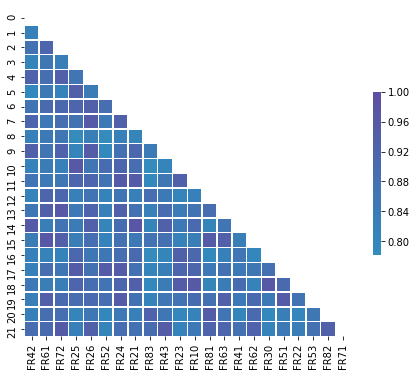

In [19]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0, square=True, cmap='Spectral', linewidths=.5, cbar_kws={"shrink": .5}) #annot=True

In [20]:
df.groupBy("month").agg(mean('FR10').alias('avg solar efficiency'), count('FR10')).sort('month', ascending=True).show()

+-----+--------------------+-----------+
|month|avg solar efficiency|count(FR10)|
+-----+--------------------+-----------+
|    1| 0.05483142473118275|       2976|
|    2|  0.0876571755162243|       2712|
|    3| 0.11957412970430109|       2976|
|    4| 0.16201756944444456|       2880|
|    5| 0.17841632056451606|       2976|
|    6| 0.18839006944444447|       2880|
|    7| 0.19074494959677418|       2976|
|    8| 0.18161244623655903|       2976|
|    9| 0.14746095833333325|       2880|
|   10| 0.10352561192701372|       2247|
|   11| 0.07694935185185191|       2160|
|   12|0.048144126344086005|       2232|
+-----+--------------------+-----------+



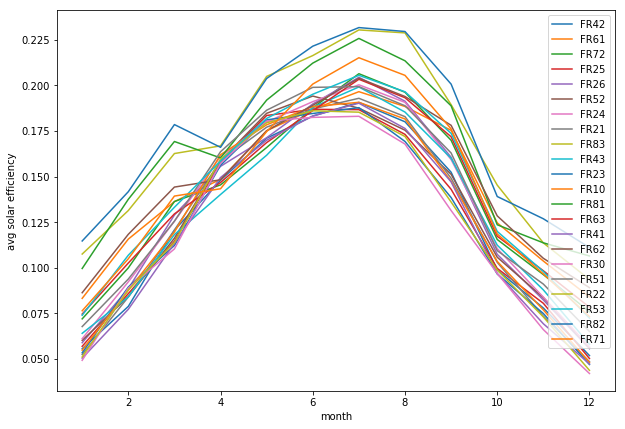

In [21]:
plt.figure(figsize=(10, 7))
for c in df.columns:
    if c not in ['date_time', 'month', 'day_of_year', 'hour']:
        temp_df = df.groupBy("month").agg(mean(c).alias('avg solar efficiency'))
        sns.lineplot(x="month", y="avg solar efficiency", data=temp_df.toPandas(), label=c)
plt.show()

In [22]:
df.groupBy("hour").agg(mean('FR10').alias('avg solar efficiency'), count('FR10')).sort('hour', ascending=True).show(24)

+----+--------------------+-----------+
|hour|avg solar efficiency|count(FR10)|
+----+--------------------+-----------+
|   0|                 0.0|       1370|
|   1|                 0.0|       1370|
|   2|                 0.0|       1370|
|   3|                 0.0|       1370|
|   4|                 0.0|       1370|
|   5|0.004097065693430661|       1370|
|   6| 0.02790808759124087|       1370|
|   7| 0.09689045985401452|       1370|
|   8| 0.19820466423357644|       1370|
|   9|  0.3067323284671529|       1370|
|  10| 0.37464137956204346|       1370|
|  11| 0.41433356934306503|       1370|
|  12| 0.42196337226277375|       1370|
|  13|  0.4036360072992697|       1370|
|  14|  0.3519554890510952|       1370|
|  15|  0.2824759386413445|       1369|
|  16| 0.18202967859751643|       1369|
|  17| 0.07868802775748716|       1369|
|  18|0.018060314097881662|       1369|
|  19|0.003768064280496...|       1369|
|  20|                 0.0|       1369|
|  21|                 0.0|       1369|


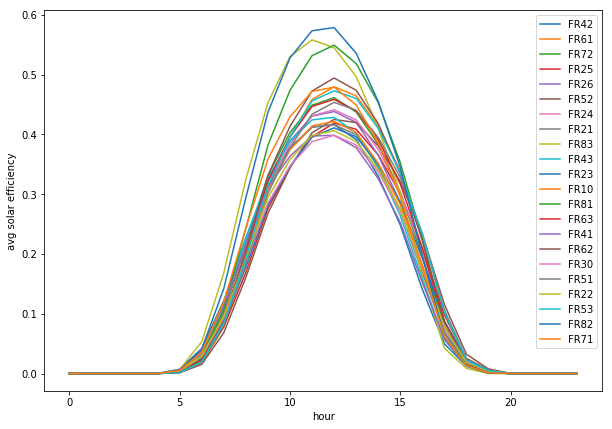

In [23]:
plt.figure(figsize=(10, 7))
for c in df.columns:
    if c not in ['date_time', 'month', 'day_of_year', 'hour']:
        temp_df = df.groupBy("hour").agg(mean(c).alias('avg solar efficiency'))
        sns.lineplot(x="hour", y="avg solar efficiency", data=temp_df.toPandas(), label=c)
plt.show()

In [24]:
df = df.withColumn("year", month(df.date_time).alias('year'))
temp_df = df.filter(df.year > 2006)

In [ ]:
temp_df = df[df.year >]

In [ ]:
df.groupBy("hour").agg(mean('FR10').alias('avg solar efficiency'), count('FR10')).sort('hour', ascending=True).show(24)

In [ ]:
plt.figure(figsize=(14, 9))
sns.lineplot(x = df_solar_co.time, y = df_solar_co['FR'])

---

# 3. Predictions with various ML models